# Mounting and Installation of Package

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
cd /content/drive/My\ Drive/Colab\ Notebooks/adversarial_reisz

/content/drive/My Drive/Colab Notebooks/adversarial_reisz


In [2]:
!python setup.py develop

running develop
running egg_info
writing advreisz.egg-info\PKG-INFO
writing dependency_links to advreisz.egg-info\dependency_links.txt
writing top-level names to advreisz.egg-info\top_level.txt
reading manifest file 'advreisz.egg-info\SOURCES.txt'
writing manifest file 'advreisz.egg-info\SOURCES.txt'
running build_ext
Creating c:\programdata\anaconda3\lib\site-packages\advreisz.egg-link (link to .)
advreisz 0.0.1 is already the active version in easy-install.pth

Installed c:\users\vasy\google drive\colab notebooks\adversarial_reisz
Processing dependencies for advreisz==0.0.1
Finished processing dependencies for advreisz==0.0.1


In [3]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
import scipy.special

# Data Generation

In [228]:
def nonlin(x):
    # return 1.5 * (x[:, 1]**2)
    return scipy.special.expit(10 * x[:, 1])
    # return np.abs(x[:, 1])
    # return 1.5*scipy.special.expit(10 * x[:, 1]) - 1.5*scipy.special.expit(10 * x[:, 2])

def true_propensity(X):
    return .5 + .3 * nonlin(X)

def true_f(X):
    return X[:, 0] + nonlin(X)

def gen_data(n, p):
    X = np.random.uniform(-1, 1, size=(n, p))
    X[:, 0] = np.random.binomial(1, true_propensity(X))
    y = true_f(X) + np.random.normal(size=(n,))
    return X, y

np.random.seed(123)
n = 10000
p = 3
X, y = gen_data(n, p)
X_test, y_test = gen_data(n, p)

# Moment Definition

In [295]:
def moment_fn(x, test_fn):
    t1 = test_fn(np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]]))
    t0 = test_fn(np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]]))
    return t1 - t0

def true_reisz(X):
    return (X[:, 0]==1) / true_propensity(X) - (X[:, 0]==0)/(1 - true_propensity(X))

# Adversarial Reisz Estimator

In [296]:
from advreisz.linear import SparseLinearAdvRiesz

In [297]:
from sklearn.base import BaseEstimator, TransformerMixin
class SeparateFeaturizer(TransformerMixin, BaseEstimator):
    
    def __init__(self, featurizer):
        self.featurizer = featurizer
    def transform(self, X):
        T = X[:, [0]]
        feats = self.featurizer.transform(X[:, 1:])
        return np.hstack([T * feats, (1 - T) * feats])
    def fit_transform(self, X, y=None):
        T = X[:, [0]]
        feats = self.featurizer.fit_transform(X[:, 1:])
        return np.hstack([T * feats, (1 - T) * feats])
    def fit(self, X, y=None):
        return self
    def get_feature_names(self):
        return ['T0 * {}'.format(i) for i in self.featurizer.get_feature_names()] +\
                ['T1 * {}'.format(i) for i in self.featurizer.get_feature_names()]

In [298]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.pipeline import Pipeline

# feat = Pipeline([('p', PolynomialFeatures(degree=3, include_bias=False))])
feat = Pipeline([('nys', Nystroem(n_components=100, kernel='rbf', gamma=5, degree=3)),
                   ('p', PolynomialFeatures(degree=1, include_bias=True))])
# feat = Pipeline([('nys', RBFSampler(n_components=100, gamma=2)),
#                    ('p', PolynomialFeatures(degree=1, include_bias=True))])
# feat = Pipeline([('p', SeparateFeaturizer(feat))])
feat.steps.append(('s', StandardScaler()))
feat.steps.append(('cnt', PolynomialFeatures(degree=1, include_bias=True)))
splin = SparseLinearAdvRiesz(moment_fn, featurizer=feat,
                             n_iter=10000, lambda_theta=0.001, B=10,
                             tol=0.00001).fit(X)

C:\Users\vasy\Google Drive\Colab Notebooks\adversarial_reisz\advreisz\linear\sparse_linear.py:175: UserWarning: Maximum number of iterations reached and duality gap tolerance not achieved. Consider increasing the maximum number of iterations.
  warnings.warn("Maximum number of iterations reached and duality gap tolerance not achieved. "


In [299]:
coefs = splin.coef
print("Maximum violation: ", splin.max_violation_)
#print("Estimated non-zero coefs: ", np.array(list(zip(splin.get_feature_names(), coefs))))
print("Min/Max: ", splin.min_response_loss_, splin.max_response_loss_)
print("Dualit Gap: ", splin.duality_gap_)
print("Iters: ", splin.n_iters_)

Maximum violation:  0.00308782159043941
Min/Max:  0.00404177762454554 0.012290490419981991
Dualit Gap:  0.008248712795436451
Iters:  10000


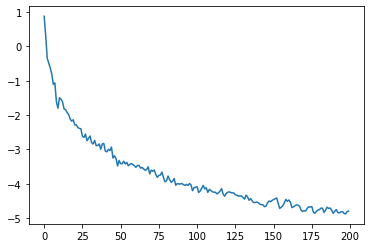

In [300]:
plt.plot(np.log(np.array(splin.duality_gaps)))
plt.show()

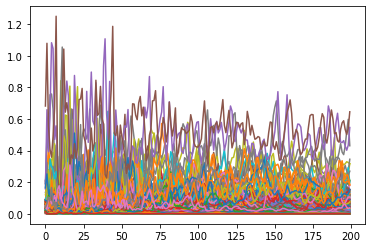

In [301]:
plt.plot(np.exp(np.array(splin.log_theta_list)))
plt.show()

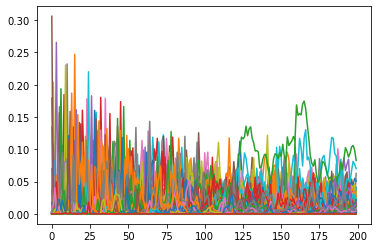

In [302]:
plt.plot(np.exp(np.array(splin.log_w_list)))
plt.show()

# Evaluation of Learned Reisz Representer

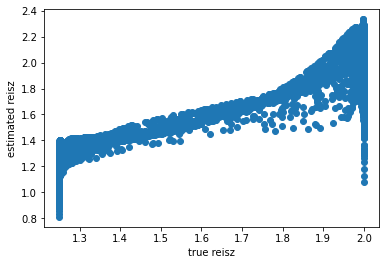

In [303]:
plt.figure()
treated = (X_test[:, 0] == 1)
plt.scatter(true_reisz(X_test[treated]), splin.predict(X_test[treated]))
plt.xlabel('true reisz')
plt.ylabel('estimated reisz')
plt.show()

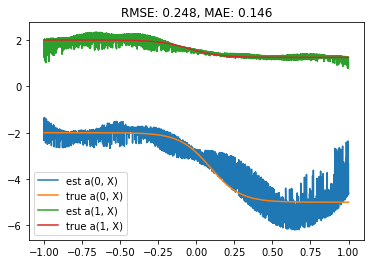

In [304]:
plt.figure()
error = true_reisz(X_test) - splin.predict(X_test)
plt.title("RMSE: {:.3f}, MAE: {:.3f}".format(np.sqrt(np.mean(error**2)), np.mean(np.abs(error))))
for t in [0, 1]:
    treated = (X_test[:, 0]==t)
    Xtreated = X_test[treated].copy()
    Xtreated[:, 1] = np.linspace(-1, 1, Xtreated.shape[0])
    plt.plot(Xtreated[:, 1], splin.predict(Xtreated), label='est a({}, X)'.format(t))
    plt.plot(Xtreated[:, 1], true_reisz(Xtreated), label='true a({}, X)'.format(t))
plt.legend()
plt.show()

# Debiasing ATE

Applying the learned Reisz representer in order to debias a preliminary regression based model of the ATE

In [305]:
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV
from sklearn.pipeline import Pipeline

est = Lasso(alpha=0.1).fit(X, y)
propensity = Pipeline([('p', PolynomialFeatures(degree=3)), ('l', LogisticRegressionCV())]).fit(X[:, 1:], X[:, 0])

In [306]:
a_test = splin.predict(X_test)
prop_test = propensity.predict_proba(X_test[:, 1:])[:, 1]
invp_test = (X_test[:, 0]==1)/prop_test - 2* (X_test[:, 0]==0)/(1 - prop_test)
true_ate = np.mean(moment_fn(X_test, true_f))
naive_ate = np.mean(y_test[X_test[:, 0]==1]) - np.mean(y_test[X_test[:, 0]==0])
biased_ate = np.mean(moment_fn(X_test, est.predict))
ips_ate = np.mean(invp_test * y_test)
reisz_ate = np.mean(a_test * y_test)
dr_ate = biased_ate + np.mean(invp_test * (y_test - est.predict(X_test)))
dr_reisz_ate = biased_ate + np.mean(a_test * (y_test - est.predict(X_test)))

In [307]:
print("True ATE: {:.3f}".format(true_ate))
print("Mean of Treated - Mean of Untreated: {:.3f}".format(naive_ate))
print("Lasso Regression based Estimate: {:.3f}".format(biased_ate))
print("IPS estimate with explicit propensity based reisz estimate (i.e. mean(a(X) Y)): {:.3f}".format(ips_ate))
print("IPS estimate with adversarial reisz: {:.3f}".format(reisz_ate))
print("DR estimate with explict propensity based reisz estimate: {:.3f}".format(dr_ate))
print("DR estimate with adversarial reisz: {:.3f}".format(dr_reisz_ate))

True ATE: 1.000
Mean of Treated - Mean of Untreated: 1.296
Lasso Regression based Estimate: 0.633
IPS estimate with explicit propensity based reisz estimate (i.e. mean(a(X) Y)): 0.569
IPS estimate with adversarial reisz: 1.038
DR estimate with explict propensity based reisz estimate: 1.285
DR estimate with adversarial reisz: 1.018


In [ ]:
dr_reisz_ate = []
reisz_ate = []
biased_ate = []
for exp in range(1000):
    Xboot, yboot = gen_data(n, p)
    t1 = np.hstack([np.ones((Xboot.shape[0], 1)), Xboot[:, 1:]])
    t0 = np.hstack([np.zeros((Xboot.shape[0], 1)), Xboot[:, 1:]])
    aboot = splin.predict(Xboot)
    dr_reisz_ate.append(np.mean(est.predict(t1) - est.predict(t0) + aboot * (yboot - est.predict(Xboot))))
    reisz_ate.append(np.mean(aboot * yboot))

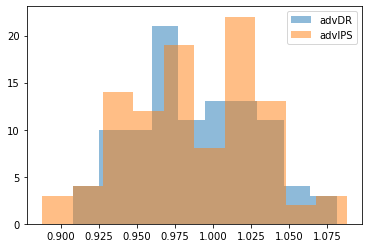

In [1282]:
plt.hist(np.array(dr_reisz_ate), alpha=.5, label='advDR')
plt.hist(np.array(reisz_ate), alpha=.5, label='advIPS')
plt.legend()
plt.show()